# Nepal Earthquake

### Context

In April of 2015 the 7.8 magnitude Gorkha earthquake occured near the Gorkha district of Gandaki Pradesh, Nepal. Almost 9,000 lives were lost, millions of people were instantly made homeless, and $10 billion in damages––about half of Nepal's nominal GDP––were incurred. In the years since, the Nepalese government has worked intensely to help rebuild the affected districts' infrastructures.

One of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.

### Import Libraries and Set Data Source 

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder,OrdinalEncoder

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.utils.validation import check_is_fitted

In [3]:
import sqlite3
%load_ext sql
%sql sqlite:///nepalDB.db

In [4]:
%%sql
select * from id_map limit 5

 * sqlite:///nepalDB.db
Done.


household_id,district_id,vdcmun_id,building_id
12010100001101,12,1207,1
12010100002101,12,1207,2
12010100003101,12,1207,3
12010100004101,12,1207,4
12010100005101,12,1207,5


### Prepare Data

In [5]:
%%sql
select distinct (district_id) from id_map

 * sqlite:///nepalDB.db
Done.


district_id
12
20
21
22
23
24
28
29
30
31


In [6]:
%sql select count(distinct(building_id)) from id_map

 * sqlite:///nepalDB.db
Done.


count(distinct(building_id))
747365


### Prepare query to fetch data relevant to building damage

In [7]:
%%sql
SELECT DISTINCT im.building_id AS b_id,
    bs.*,
    bd.damage_grade
  FROM temp_map1 tm
       JOIN
       building_structure AS bs ON tm.building_id = bs.building_id
       JOIN 
       building_damage AS bd ON tm.building_id = bd.building_id
       JOIN
       id_map AS im ON im.household_id =tm.household_id 
       where im.district_id=36
        limit 5



 * sqlite:///nepalDB.db
Done.


b_id,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
671455,360101000011,36,3609,360903,1,0,40,336,6,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,Grade 5
671456,360101000021,36,3609,360903,2,2,12,420,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 3
671457,360101000031,36,3609,360903,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 2
671458,360101000041,36,3609,360903,2,2,15,390,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,Grade 4
671459,360101000051,36,3609,360903,2,2,15,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,0,1,Grade 4


### Perform data Wrangling 
#### Drop cols which aren't relevant, have high cardinality, post earthqauke data , multi collinearity and most importantly which show leakage 


In [8]:
def wrangle(filepath):
    con= sqlite3.connect(filepath)
    
     # Construct query
    query = """
        SELECT DISTINCT im.building_id AS b_id,
    bs.*,
    bd.damage_grade
  FROM temp_map1 tm
       JOIN
       building_structure AS bs ON tm.building_id = bs.building_id
       JOIN 
       building_damage AS bd ON tm.building_id = bd.building_id
       JOIN
       id_map AS im ON im.household_id =tm.household_id 
       where im.district_id=36
    """
    
    #Read Query results into df
    df= pd.read_sql(query, con, index_col='b_id')
    
    #List post_eq data data
    drop_cols=[col for col in df.columns if 'post_eq' in col]
    
    #binary classification
    df['damage_grade']=df['damage_grade'].str.split(' ',expand=True)[1].astype(int)
    df['severity']=(df['damage_grade']>3).astype(int)
    
    #Drop cols for binary classification
    drop_cols.append('damage_grade')
    
    #Drop cols for high cardinality/ leakage/ non relevance
    drop_cols.append('building_id')
    drop_cols.append('district_id')
    drop_cols.append('vdcmun_id')
    drop_cols.append('ward_id')
    
    # Drop cols for low multi collinearity 
    drop_cols.append('count_floors_pre_eq')
    
    #Drop cols
    df.drop(columns=drop_cols, inplace=True)
    
    return df


In [9]:
df=wrangle('./nepalDB.db')
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severity
b_id,,,,,,,,,,,,
671455,40,336,6,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1,1
671456,12,420,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0
671457,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0
671458,15,390,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,1
671459,15,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,1,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75883 entries, 671455 to 747365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            75883 non-null  int64 
 1   plinth_area_sq_ft       75883 non-null  int64 
 2   height_ft_pre_eq        75883 non-null  int64 
 3   land_surface_condition  75883 non-null  object
 4   foundation_type         75883 non-null  object
 5   roof_type               75883 non-null  object
 6   ground_floor_type       75883 non-null  object
 7   other_floor_type        75883 non-null  object
 8   position                75883 non-null  object
 9   plan_configuration      75883 non-null  object
 10  superstructure          75883 non-null  object
 11  severity                75883 non-null  int32 
dtypes: int32(1), int64(3), object(8)
memory usage: 7.2+ MB


In [11]:
df['severity'].value_counts()

1    47885
0    27998
Name: severity, dtype: int64

### Perform Exploratory Data Analysis


                   age_building  plinth_area_sq_ft  height_ft_pre_eq
age_building           1.000000          -0.021963          0.035365
plinth_area_sq_ft     -0.021963           1.000000          0.330765
height_ft_pre_eq       0.035365           0.330765          1.000000


Text(0.5, 1.0, 'Collinearity among numerical features Heat Map')

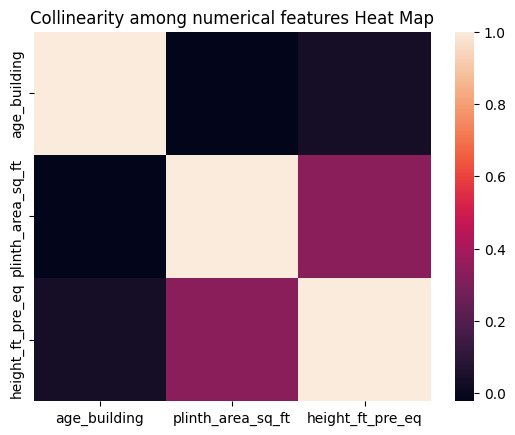

In [12]:
correlation=df.select_dtypes('number').drop(columns='severity').corr()
print(correlation)
sns.heatmap(correlation)
plt.title('Collinearity among numerical features Heat Map')

In [13]:
df['severity'].corr(df['height_ft_pre_eq'])

-0.08591905510494374

In [14]:
# df['severity'].corr(df['count_floors_pre_eq'])

Text(0.5, 1.0, 'Distribution of Building Height by Class')

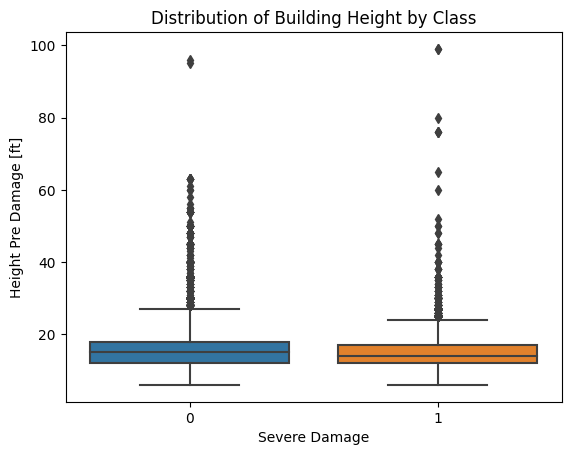

In [15]:
#Create boxplot

sns.boxplot(x='severity', y='height_ft_pre_eq', data=df)

#Labelling Axes
plt.xlabel('Severe Damage')
plt.ylabel('Height Pre Damage [ft]')
plt.title("Distribution of Building Height by Class")

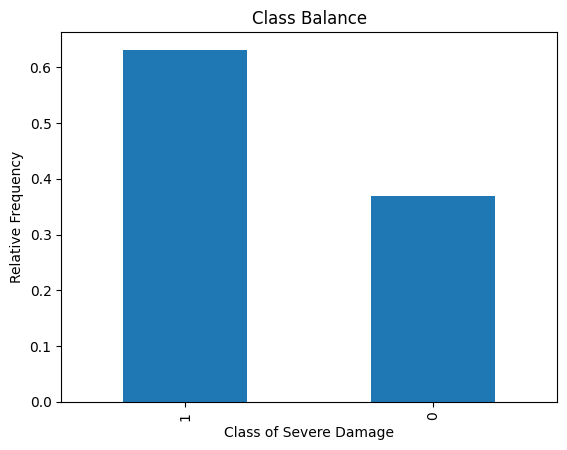

In [16]:
# Plot value counts of `"severe_damage"`
df['severity'].value_counts(normalize=True).plot(
    kind='bar',
    xlabel='Class of Severe Damage',
    ylabel='Relative Frequency',
    title='Class Balance'
);

In [17]:
majority_class_prop, minority_class_prop= df['severity'].value_counts(normalize=True)

print(majority_class_prop, minority_class_prop)

0.6310372547210837 0.3689627452789162


Pivot Table

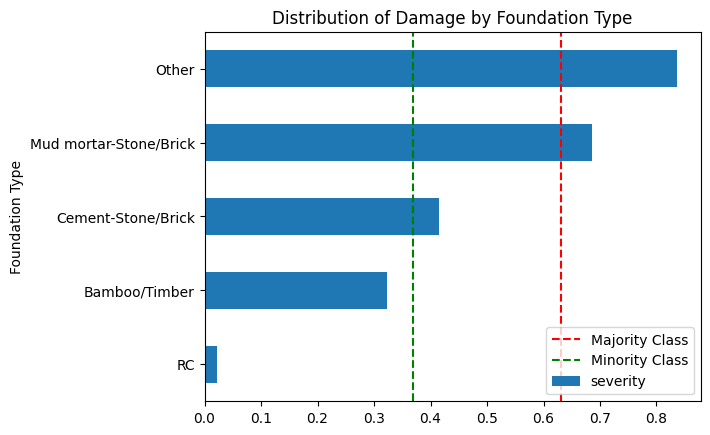

In [18]:
# Create pivot table
# Plot bar chart of `foundation_pivot`
foundation_pivot = pd.pivot_table(
    df,
    index='foundation_type',
    values='severity',
    aggfunc=np.mean
).sort_values(by='severity').plot(
    kind='barh',
    xlabel='Foundation Type',
    title='Distribution of Damage by Foundation Type',
    label='Severity of Damage'
);

plt.axvline(majority_class_prop, linestyle='--',color='red', label='Majority Class' );
plt.axvline(minority_class_prop, linestyle='--',color='green', label='Minority Class' );
plt.legend(loc='lower right');

### Split

In [19]:
target = "severity"
X = df.drop(columns=target)
y = df[target]

In [20]:
X_train, X_test, y_train, y_test =  train_test_split(
    X,y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60706, 11)
y_train shape: (60706,)
X_test shape: (15177, 11)
y_test shape: (15177,)


In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (48564, 11)
y_train shape: (48564,)
X_val shape: (12142, 11)
y_val shape: (12142,)


### Build Model

#### Baseline

In [22]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


### Perform Logistic Regression

#### Iterate

In [23]:
# Build model
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
) 
# Fit model to training data
model_lr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

#### Evaluate

In [24]:
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.72
Test Accuracy: 0.71


### Communicate

In [25]:
y_train_pred = model_lr.predict(X_train)
y_train_pred_proba = model_lr.predict_proba(X_train)
print(y_train_pred[:5])
print(y_train_pred_proba[:5])

[1 0 1 1 1]
[[0.46447864 0.53552136]
 [0.97802285 0.02197715]
 [0.33528852 0.66471148]
 [0.3064669  0.6935331 ]
 [0.32262636 0.67737364]]


#### Extract the feature names and importances from your model

In [26]:
features = model_lr.named_steps['onehotencoder'].get_feature_names()
importances = model_lr.named_steps['logisticregression'].coef_[0]

####  Series odds_ratios, where the index is features and the values are your the exponential of the importances

In [27]:
odds_ratios =  pd.Series(np.exp(importances), index= features).sort_values()
odds_ratios.head()

foundation_type_RC               0.303679
roof_type_RCC/RB/RBC             0.345858
ground_floor_type_RC             0.384236
other_floor_type_RCC/RB/RBC      0.467340
foundation_type_Bamboo/Timber    0.470415
dtype: float64

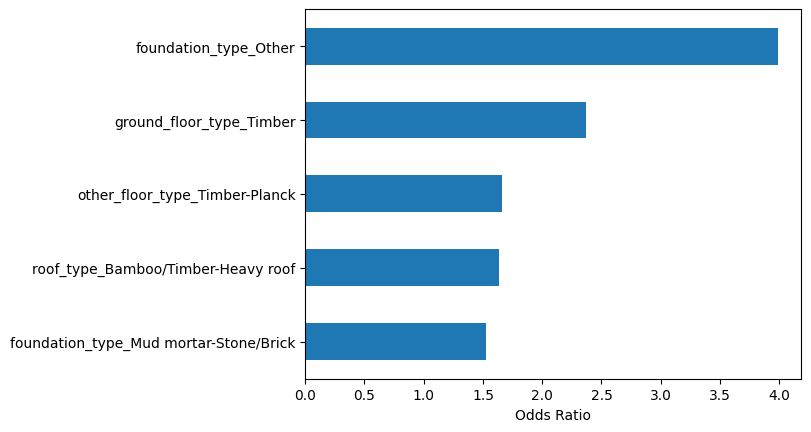

In [28]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind='barh')
plt.xlabel('Odds Ratio');

#### Plot Odds Ratio

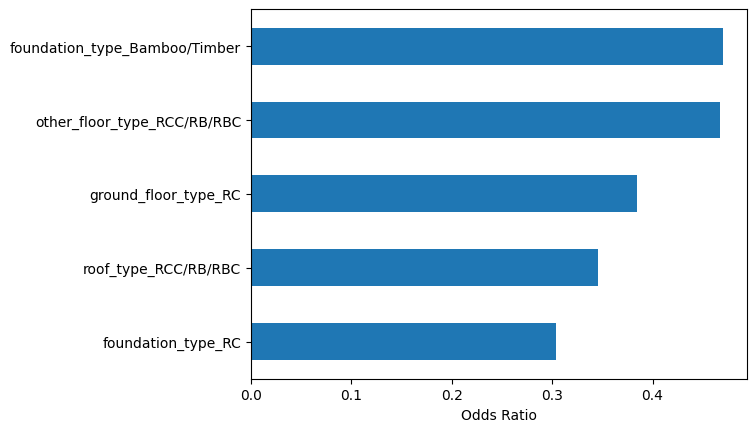

In [29]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind='barh')
plt.xlabel('Odds Ratio');

### Until now I have done some EDA and make a prediction model for predicting the damage over a building using Logistic Regression Model  
#### Now will make a predition model using a Decision tree Classifier to predict severity of damage
#### Tune hyperparameters ie., make changes to depth of the tree to tune predictions.
#### Explain model prediction using Gini Importance

### Decision Tree Classifier

In [30]:
# X_train, X_val, y_train, y_val = train_test_split(
    # X_train, y_train, test_size=0.2, random_state=42
# )
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)

X_train shape: (48564, 11)
y_train shape: (48564,)


Splitting Data with Validation Set

In [31]:
# acc_baseline = y_train.value_counts(normalize=True).max()
# print("Baseline Accuracy:", round(acc_baseline, 2))

#### Iterate

In [32]:
model_dt=make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(max_depth=15,random_state=42))

model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Steep slope       2
Moderate slope    3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
                                         {'col': 'plan_configuration',
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
Multi-projected                     2
L-shape                             3
Square                              4
T-shape                             5
Others                              6
U-shape                             7
H-shape                             8
E-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': 1      1
0      2
NaN   -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=15, random_state=42))])

In [33]:
acc_train = accuracy_score(y_train, model_dt.predict(X_train))
acc_val = model_dt.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.77
Validation Accuracy: 0.71


In [34]:
tree_depth = model_dt.named_steps['decisiontreeclassifier'].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 15


In [35]:
depth_hyperparams=range(1,50)
training_acc=[]
val_acc=[]

for d in depth_hyperparams:
    
    #Create model of depth d
    test_model=make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d,random_state=42)
    )
    
    #Fit model
    test_model.fit(X_train, y_train)
    
    #Calc training acc and append to training acc
    training_acc.append(test_model.score(X_train,y_train))
    
    #Calc val acc and append to val acc
    val_acc.append(test_model.score(X_val,y_val))
    

print("Training Accuracy Score", training_acc)
print("Val Accuracy Score", val_acc)

Training Accuracy Score [0.696524174285479, 0.7012807841199242, 0.7099497570216622, 0.7125442714768141, 0.7141709908574253, 0.7170743760810477, 0.7192776542294704, 0.7219133514537518, 0.7269994234412321, 0.7329297421958653, 0.7397866732559097, 0.7466847870850836, 0.7546742442961865, 0.7625401531999012, 0.7715591796392389, 0.7823696565357054, 0.7936331438925953, 0.803887653405815, 0.8155011943003048, 0.8274441973478297, 0.8405403179309777, 0.8526480520550201, 0.8652293880240507, 0.8763281443044231, 0.887653405815007, 0.8991639897866732, 0.9105922082200807, 0.9212379540400296, 0.9307923564780496, 0.9398937484556461, 0.9480685281278313, 0.9547813194959229, 0.9606704554814266, 0.9657771188534717, 0.9703072234577053, 0.9730458776048101, 0.9759080800593032, 0.9776995305164319, 0.9792232929742196, 0.9802940449715839, 0.9811588831233012, 0.9816942591219834, 0.9821472695824067, 0.9824767317354419, 0.9826414628119595, 0.982744419734783, 0.982806193888477, 0.9828679680421711, 0.9828679680421711]


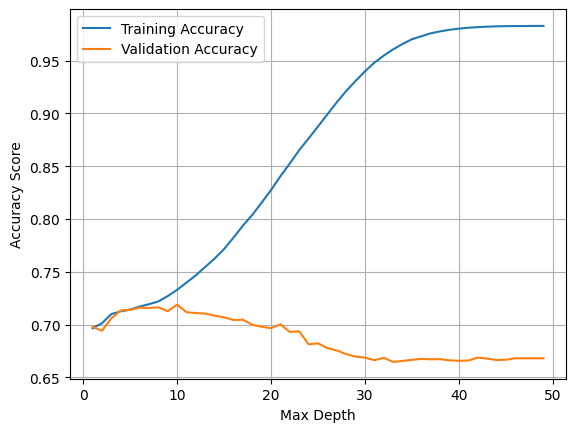

In [36]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label='Training Accuracy')
plt.plot(depth_hyperparams, val_acc, label= 'Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid()
plt.show();

#### Now after tuning params I ahve realised the ideal max depth for this model is 9 to get maximum accuracy as thats the highest Validation accuracy it achieved

In [37]:
val_acc.index(max(val_acc))

9

In [39]:
test_acc=model_dt.score(X_test,y_test)
print("Test Accuracy:", round(test_acc,2) )

Test Accuracy: 0.71


### Communicate Result

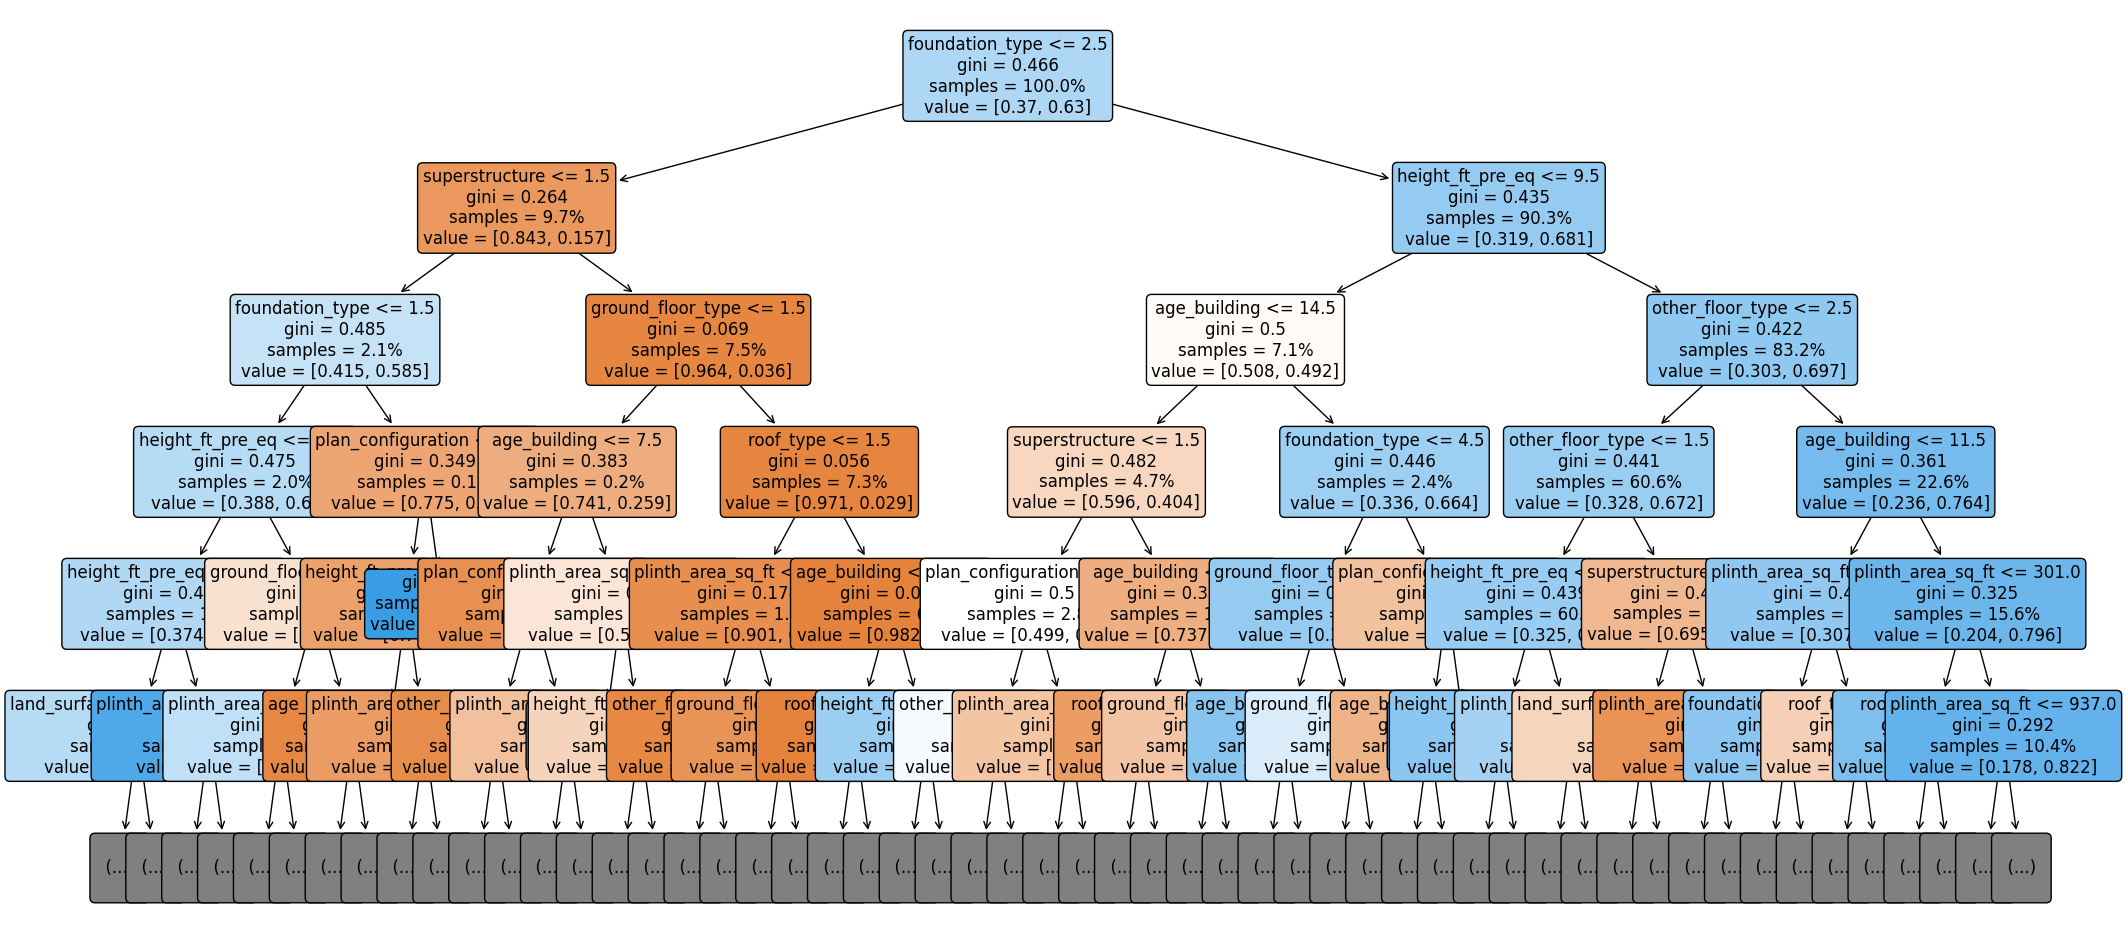

In [44]:
#Create large fig

fig, ax= plt.subplots(figsize=(25,12))

# PLot tree
plot_tree(
    decision_tree=model_dt.named_steps['decisiontreeclassifier'],
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=5,
    fontsize=12,
    ax=ax
);


In [45]:
features = X_train.columns
importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.11811291 0.16364019 0.13594238]


In [47]:
feat_imp=pd.Series(importances, index=features).sort_values()
feat_imp


plan_configuration        0.014055
position                  0.026700
land_surface_condition    0.027180
roof_type                 0.030024
other_floor_type          0.034649
ground_floor_type         0.041038
superstructure            0.089264
age_building              0.118113
height_ft_pre_eq          0.135942
plinth_area_sq_ft         0.163640
foundation_type           0.319397
dtype: float64

In [50]:
print(f'Total of feature importance: {feat_imp.sum()}')

Total of feature importance: 1.0


### Gini importance of different features. 


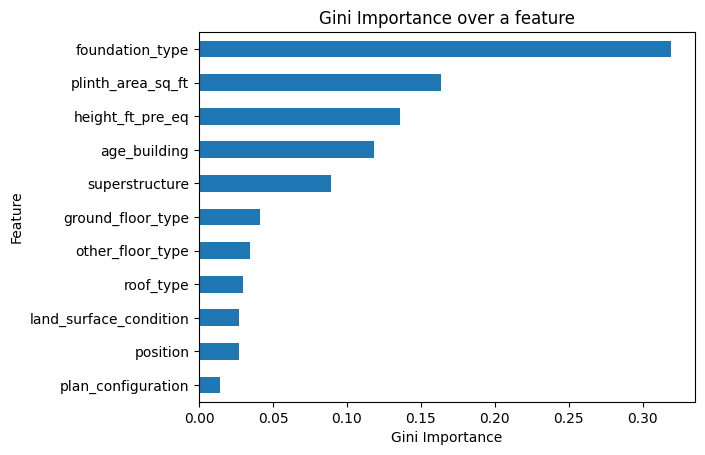

In [51]:
# Create horizontal bar chart
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Gini Importance over a feature');

#### To sum it up it means foundation type has 30% importance, Plinth area has around 16% and so on in deciding the fate of the building 